In [2]:
# Import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, beta, truncnorm

In [3]:
# Define uncertainty functions
def EU(alpha):
  alpha = np.array(alpha)
  lamb=0.25
  S=np.sum(alpha)
  b = S-alpha
  min = 0
  max = 0.5
  c = beta.ppf(0.5+lamb, alpha, b)
  for i in range(10000):
    if abs(sum(c) - 1) < 1e-12: break
    if(sum(c)>1):
      max = lamb
    elif(sum(c)<1):
      min = lamb
    lamb = (min + max)/2
    c = beta.ppf(0.5+lamb, alpha, b)

  means = alpha/S
  Fa1s = beta.cdf(c, alpha+1, b)
  Fas = beta.cdf(c, alpha, b)
  eu1 = np.sum(means * (Fas - Fa1s))
  return eu1, c

def entropy(p):
  ent = -(p*np.log2(p, where=p>0, out=np.zeros_like(p)) + (1-p)*np.log2(1-p, where=(1-p)>0, out=np.zeros_like(p)))
  return ent

def distance_unc(a, b ,dist = 'unif',std=0.1, n = int(float(10e6))):
  if dist == 'unif':
    m = (a+b)/2
    q = m
    sample = np.random.uniform(a,b,n)
  elif dist == 'normal':
    m = (a+b)/2
    q = m
    a,b = (a-m)/std, (b-m)/std
    sample = truncnorm.rvs(a, b, loc=m, scale=std, size=n)
  elif dist == 'beta':
    m = (a/(a+b))
    _, q = EU(np.array([a,b]))
    q = q[0]
    sample = np.random.beta(a,b, n)
  elif dist == 'dirac':
    m = (a+b)/2
    q = m
    sample = np.random.binomial(1,m,n).astype(np.float64)
  
  tu_dist = 1-np.max(m)
  au_dist = 1-np.max(np.stack([sample, 1-sample]), 0).mean()
  eu_dist = np.abs(q-sample).mean()
  
  tu_ent = entropy(m) /np.log2(2)
  au_ent = entropy(sample).mean() /np.log2(2)
  eu_ent = tu_ent-au_ent /np.log2(2)

  return {'tu_dist': (tu_dist*2), 'au_dist': (au_dist*2), 'eu_dist': (eu_dist*2), 'tu_ent': tu_ent, 'au_ent': au_ent, 'eu_ent': eu_ent}

In [4]:
folder_name = 'plots'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

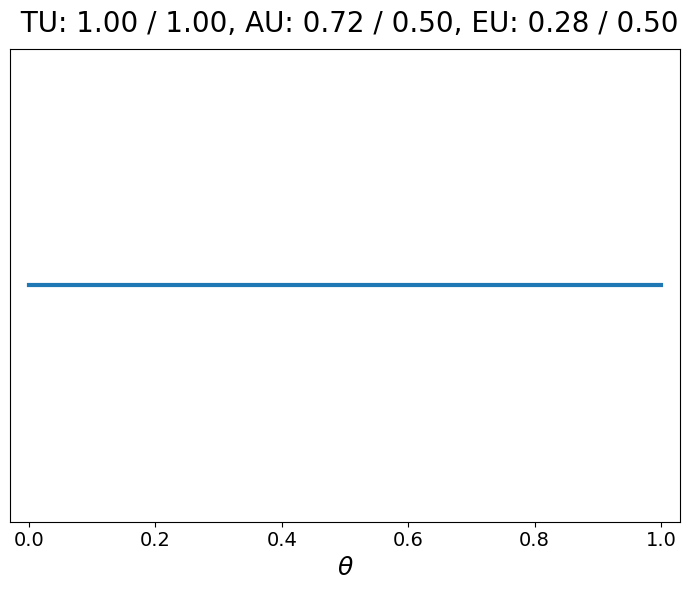

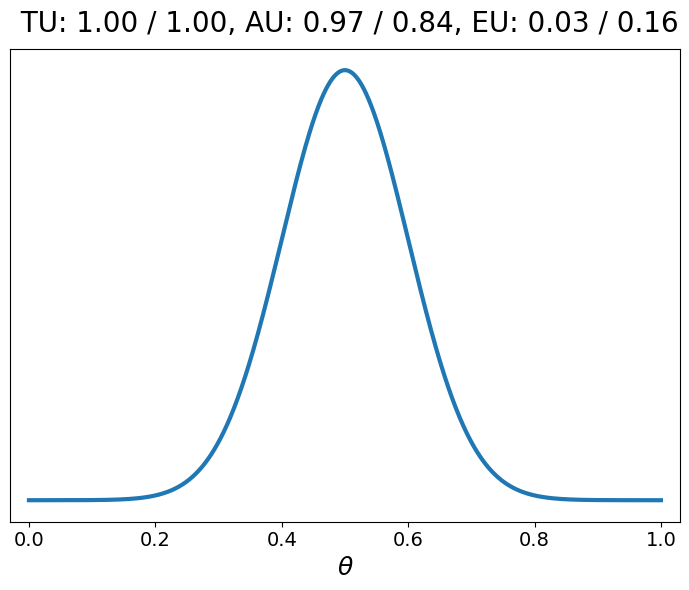

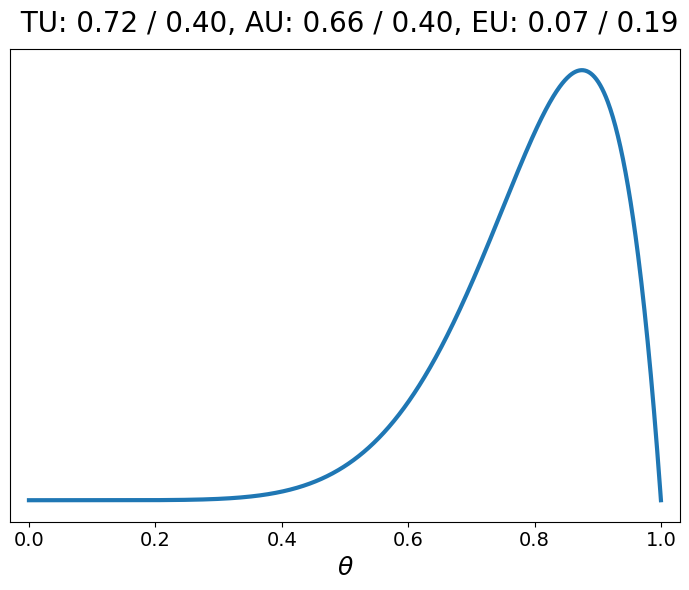

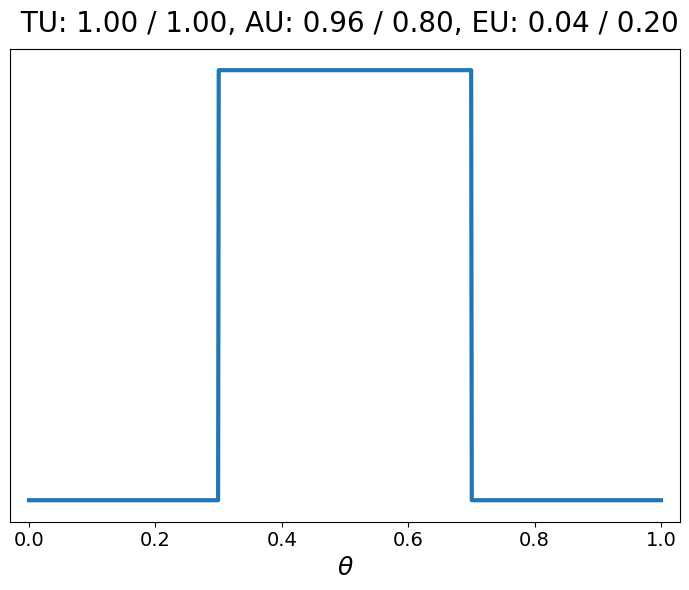

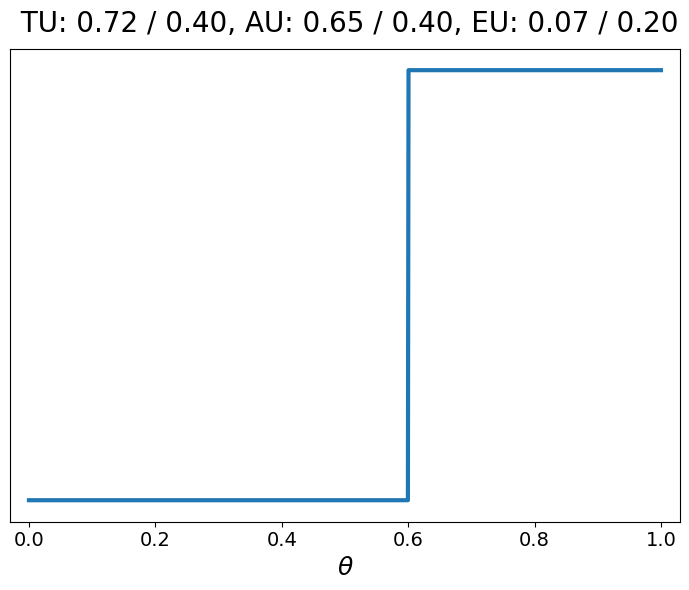

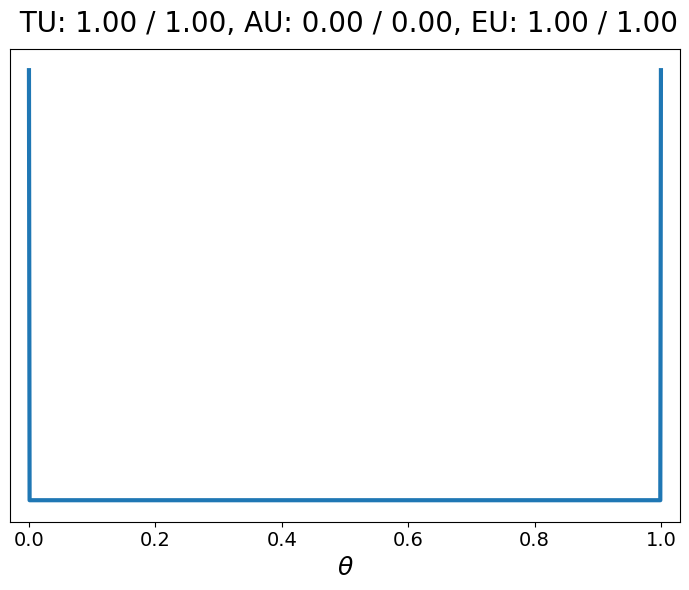

In [5]:
# Define x values
x = np.linspace(0, 1, 1000)

# Define distributions
a = np.ones(1000) # Uniform(0, 1)
b = truncnorm.pdf(x, a = (0-0.5)/0.1, b = (1-0.5)/0.1,loc=0.5, scale = 0.1) # Normal(0.5, 0.01)
c = beta.pdf(x, 8, 2) # Beta(8, 2)
d = np.where((x >= 0.3) & (x <= 0.7), 1/0.4, 0) # Uniform(0.3, 0.7)
e = np.where((x >= 0.6), 1/0.4, 0) # Uniform(0.6, 1)
f = np.where((x == 0) | (x == 1), 0.5, 0) # 1/*2δ0 + 1/2*δ1

# Define TU, AU, and EU values
param_dict = {'a': [0, 0, 8, 0.3, 0.6, 0], 'b':[1, 1, 2, 0.7, 1, 1], 'dist': ['unif', 'normal', 'beta', 'unif', 'unif', 'dirac']}
res_list = list((map(distance_unc,*param_dict.values())))
unc_dict = {k: [d[k] for d in res_list] for k in res_list[0]}

tu = unc_dict['tu_dist']
au = unc_dict['au_dist']
eu = unc_dict['eu_dist']

tu_ent = unc_dict['tu_ent']
au_ent = unc_dict['au_ent']
eu_ent = unc_dict['eu_ent']

distributions = [a, b, c, d, e, f]
titles = ['a', 'b', 'c', 'd', 'e', 'f']

for i, dist in enumerate(distributions):
    plt.figure(figsize=(7, 6))
    plt.plot(x, dist,  linewidth=3)
    plt.title(f' TU: {tu_ent[i]:.2f} / {tu[i]:.2f}, AU: {au_ent[i]:.2f} / {au[i]:.2f}, EU: {eu_ent[i]:.2f} / {eu[i]:.2f}',fontsize=20, pad=12)
    plt.xlabel(r'$\theta$',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks([]) 
    plt.xlim(-0.03, 1.03)
    plt.tight_layout()
    plt.show()